In [1]:
# TPM-Normalisierung von Count-Daten mit Vorher-Nachher-Visualisierung

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Eingabe- und Ausgabeverzeichnisse definieren
input_dir = '../data/cleaned_data_bb'
output_dir = '../data/normalized_data_bb'
os.makedirs(output_dir, exist_ok=True)

# Rekursive Suche nach .tsv-Dateien
def find_tsv_files(directory):
    tsv_files_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tsv'):
                full_path = os.path.join(root, file)
                tsv_files_list.append(full_path)
    return tsv_files_list

tsv_files = find_tsv_files(input_dir)
print(f"Gefundene .tsv-Dateien: {len(tsv_files)}")

# Rekursive Suche nach .gff-Dateien
def find_gff_files(directory):
    gff_files_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.gff3'):
                full_path = os.path.join(root, file)
                gff_files_list.append(full_path)
            if file.endswith('.gff'):
                full_path = os.path.join(root, file)
                gff_files_list.append(full_path)
    return gff_files_list

gff_files = find_gff_files('../data/raw_data_bb')
print(f"Gefundene .gff-Dateien: {len(gff_files)}")

#Extraktion der Genlänge aus der GFF-Datei
def extract_gene_lengths_from_gff(gff_file):
    gene_lengths = {}
    try:
        with open(gff_file, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                parts = line.strip().split('\t')
                if len(parts) >= 9 and parts[2] == 'gene':
                    # Berechne die Genlänge (Ende - Start + 1)
                    start = int(parts[3])
                    end = int(parts[4])
                    #'+1' da sowohl Start- als auch End-Positionen enthalten sind
                    length = end - start + 1

                    # Extrahiere die Gen-ID aus dem Attributfeld
                    attr_dict = dict(item.split('=') for item in parts[8].split(';') if '=' in item)
                    gene_id = attr_dict.get('ID', '').replace('gene:', '')

                    if gene_id:
                        gene_lengths[gene_id] = length
    except Exception as e:
        print(f"Fehler beim Lesen der GFF-Datei {gff_file}: {e}")
    return gene_lengths


# TPM-Normalisierung mit berechneten Gen-Längen/ 1000, falls keine Gen-Länge gefunden werden kann
def normalize_tpm(df, count_cols, feature_lengths):
    # Schritt 1: RPK berechnen (Reads Per Kilobase)
    rpk = pd.DataFrame()
    for col in count_cols:
        rpk[col] = df[col] / (feature_lengths / 1000)

    # Schritt 2: Skalierungsfaktor pro Sample (Summe aller RPKs pro Spalte)
    scaling_factors = rpk.sum(axis=0) / 1e6

    # Schritt 3: TPM berechnen
    tpm = rpk.divide(scaling_factors, axis=1)
    return tpm


Gefundene .tsv-Dateien: 7
Gefundene .gff-Dateien: 14


### Vorher-Nachher-Visualisierung
'visualize_tpm_boxplot_only'<br>
Diese Funktion erstellt zwei Boxplots, um die durchschnittliche Genexpression vor und nach der TPM-Normalisierung zu vergleichen. Die Werte sind nach Entity (host/phage) gruppiert und auf logarithmischer Skala dargestellt.

'visualize_tpm_boxplot_entitywise'<br>
Hier wird für jede Entity (host und phage) separat ein Vergleich der mittleren Expressionswerte vor und nach der TPM-Normalisierung gezeigt.

'visualize_pca_comparison'<br>
Diese Funktion visualisiert die Datenstruktur vor und nach der TPM-Normalisierung mithilfe einer PCA (Hauptkomponentenanalyse). Dabei werden die Gene als Punkte im 2D-Raum abgebildet, farblich getrennt nach host und phage. So lassen sich Unterschiede in der Clusterstruktur und Streuung erkennen.

In [2]:
# Visualisierung

# Boxplots Vorher-Nachher
# Visualisierung: Boxplot TPM vorher/nachher getrennt
def visualize_tpm_boxplot_only(df_before, df_after, count_cols, entity_col, file_path):
    df_before['mean_counts'] = df_before[count_cols].mean(axis=1)
    df_after['mean_tpm'] = df_after[count_cols].mean(axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.boxplot(data=df_before, x=entity_col, y='mean_counts', ax=axs[0])
    axs[0].set_yscale('log')
    axs[0].set_title('Boxplot (log) vor Normalisierung')

    sns.boxplot(data=df_after, x=entity_col, y='mean_tpm', ax=axs[1])
    axs[1].set_yscale('log')
    axs[1].set_title('Boxplot (log) nach TPM')

    plt.suptitle(f"TPM-Vergleich: {os.path.basename(file_path)}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Visualisierung 1: Boxplot TPM vorher/nachher getrennt nach Entity
def visualize_tpm_boxplot_only(df_before, df_after, count_cols, entity_col, file_path):
    df_before['mean_counts'] = df_before[count_cols].mean(axis=1)
    df_after['mean_tpm'] = df_after[count_cols].mean(axis=1)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.boxplot(data=df_before, x=entity_col, y='mean_counts', ax=axs[0])
    axs[0].set_yscale('log')
    axs[0].set_title('Boxplot (log) vor Normalisierung')

    sns.boxplot(data=df_after, x=entity_col, y='mean_tpm', ax=axs[1])
    axs[1].set_yscale('log')
    axs[1].set_title('Boxplot (log) nach TPM')

    plt.suptitle(f"TPM-Vergleich: {os.path.basename(file_path)}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()    

# Visualisierung 2:host/phage jeweils Before vs After
def visualize_tpm_boxplot_entitywise(df_before, df_after, count_cols, entity_col, file_path):

    # Copy and compute mean values
    df_before = df_before.copy()
    df_after = df_after.copy()
    df_before['mean'] = df_before[count_cols].mean(axis=1)
    df_after['mean'] = df_after[count_cols].mean(axis=1)
    df_before['Normalization'] = 'Before'
    df_after['Normalization'] = 'After'

    # Combine for both entities separately
    combined = pd.concat([df_before, df_after], ignore_index=True)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    for i, entity in enumerate(['host', 'phage']):
        subset = combined[combined[entity_col] == entity]
        if subset.empty:
            print(f"No data found for {entity}")
            continue
        sns.boxplot(x='Normalization', y='mean', data=subset, ax=axs[i])
        axs[i].set_yscale('log')
        axs[i].set_title(f"{entity.capitalize()} – TPM Before vs After")
        axs[i].set_ylabel("Mean Expression (log scale)")
        axs[i].set_xlabel("")

    plt.suptitle(f"TPM Normalization Comparison: {os.path.basename(file_path)}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Visualisierung 3: PCA-Vergleich vor und nach TPM-Normalisierung (host vs phage farblich unterschieden)
def visualize_pca_comparison(df_before, df_after, count_cols, entity_col, file_path):
    # NaN-Werte durch 0 ersetzen
    X_before = df_before[count_cols].fillna(0)
    X_after = df_after[count_cols].fillna(0)
    labels = df_before[entity_col]

    # Standardisierung der Daten
    scaler = StandardScaler()
    X_before_scaled = scaler.fit_transform(X_before)
    X_after_scaled = scaler.transform(X_after)

    # PCA auf den "before"-Datensatz fitten und beide transformieren
    pca = PCA(n_components=2)
    pc_before = pca.fit_transform(X_before_scaled)
    pc_after = pca.transform(X_after_scaled)

    # DataFrames für die PCA-Ergebnisse erstellen
    pc_df_before = pd.DataFrame(pc_before, columns=['PC1', 'PC2'])
    pc_df_before[entity_col] = labels.values

    pc_df_after = pd.DataFrame(pc_after, columns=['PC1', 'PC2'])
    pc_df_after[entity_col] = labels.values

    # Diagramme vorbereiten
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.scatterplot(data=pc_df_before, x='PC1', y='PC2', hue=entity_col,
                    palette={'host': 'blue', 'phage': 'green'}, ax=axs[0])
    axs[0].set_title('PCA vor TPM')
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')

    sns.scatterplot(data=pc_df_after, x='PC1', y='PC2', hue=entity_col,
                    palette={'host': 'blue', 'phage': 'green'}, ax=axs[1])
    axs[1].set_title('PCA nach TPM')
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')

    # Gleiche Achsenbereiche setzen für bessere Vergleichbarkeit
    xmin = min(pc_df_before['PC1'].min(), pc_df_after['PC1'].min())
    xmax = max(pc_df_before['PC1'].max(), pc_df_after['PC1'].max())
    ymin = min(pc_df_before['PC2'].min(), pc_df_after['PC2'].min())
    ymax = max(pc_df_before['PC2'].max(), pc_df_after['PC2'].max())

    axs[0].set_xlim(xmin, xmax)
    axs[1].set_xlim(xmin, xmax)
    axs[0].set_ylim(ymin, ymax)
    axs[1].set_ylim(ymin, ymax)

    # Gesamttitel hinzufügen
    plt.suptitle(f'PCA Vergleich – {os.path.basename(file_path)}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Verarbeite: Li_full_raw_counts_cleaned.tsv


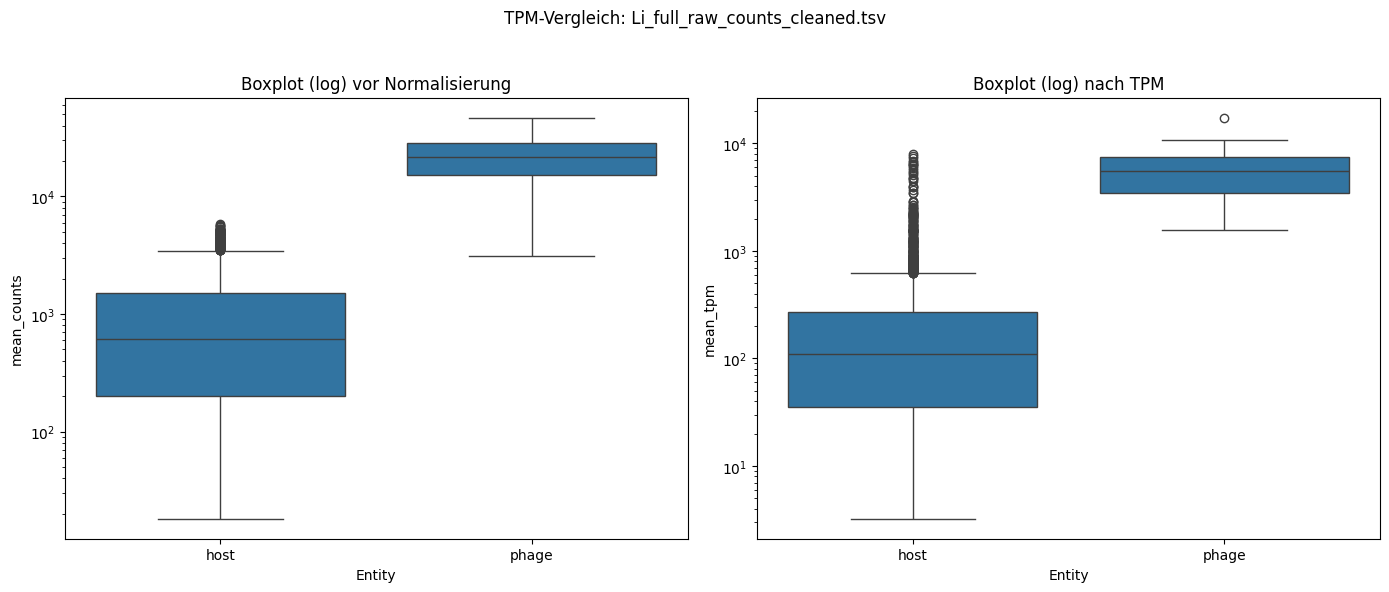

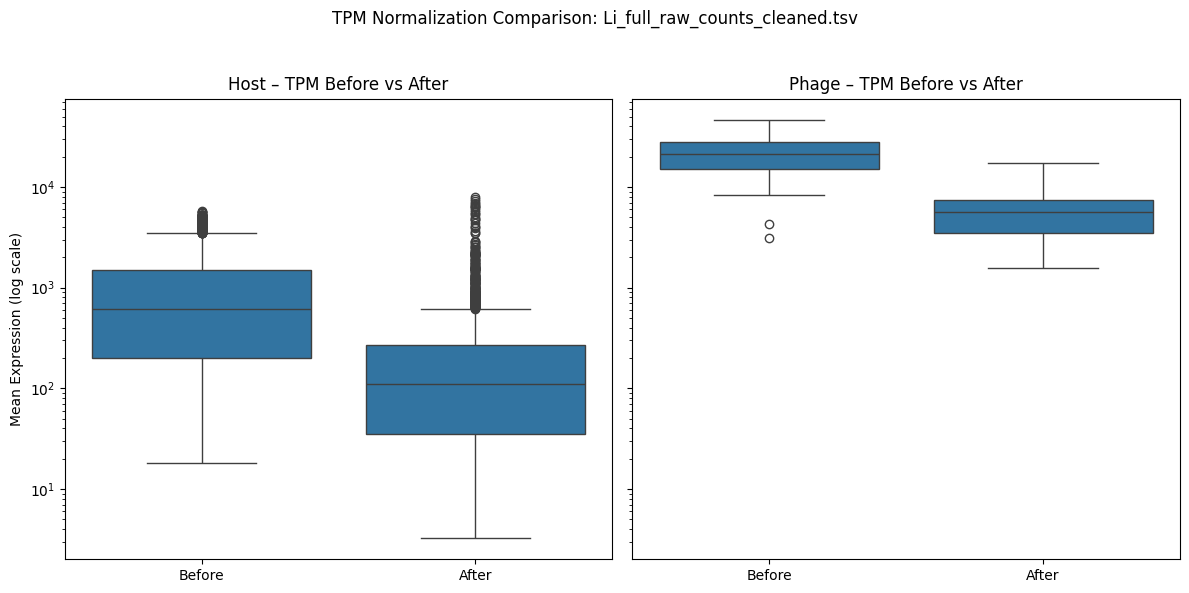

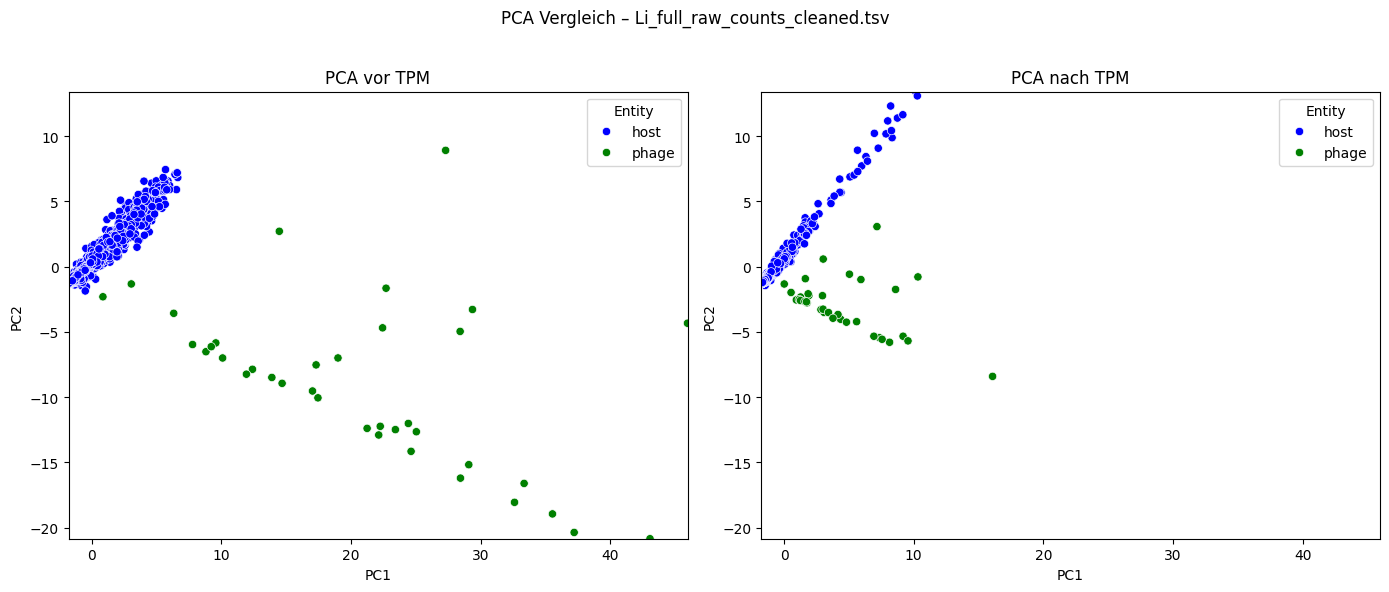

Gespeichert: ../data/normalized_data_bb/Li_full_raw_counts_cleaned_TPM.tsv

Verarbeite: Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_cleaned.tsv


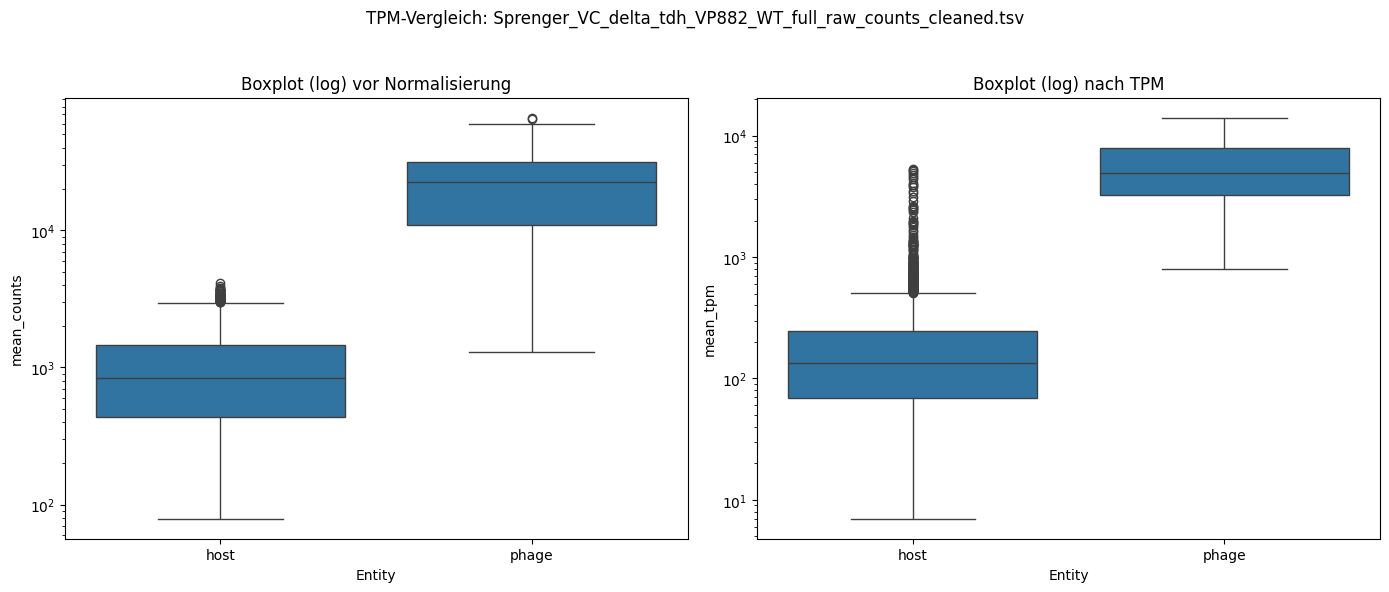

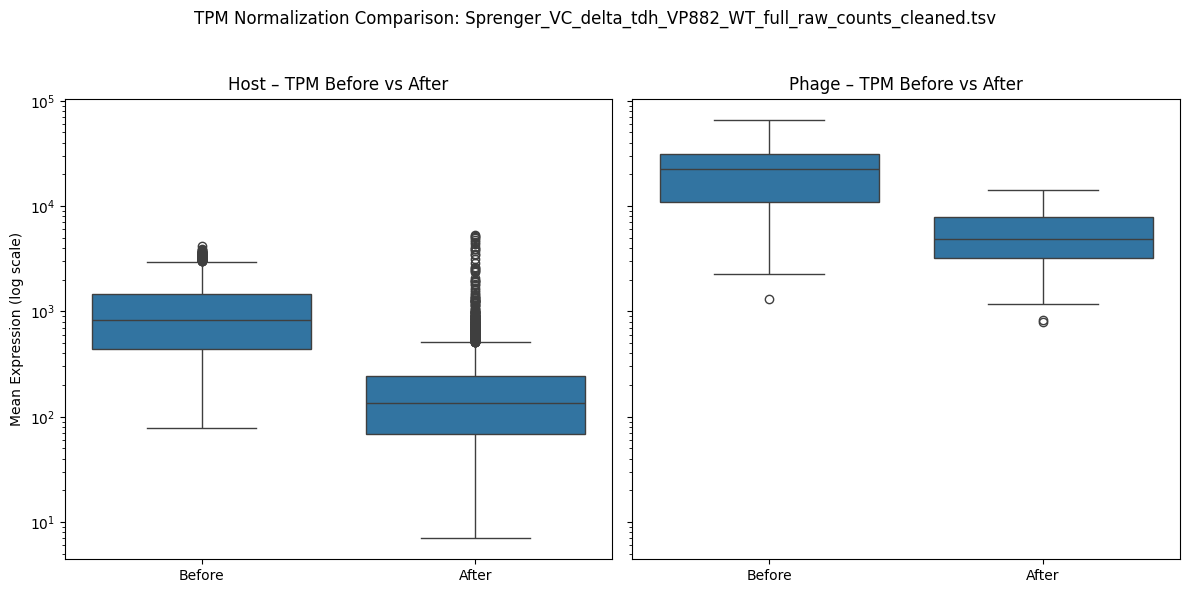

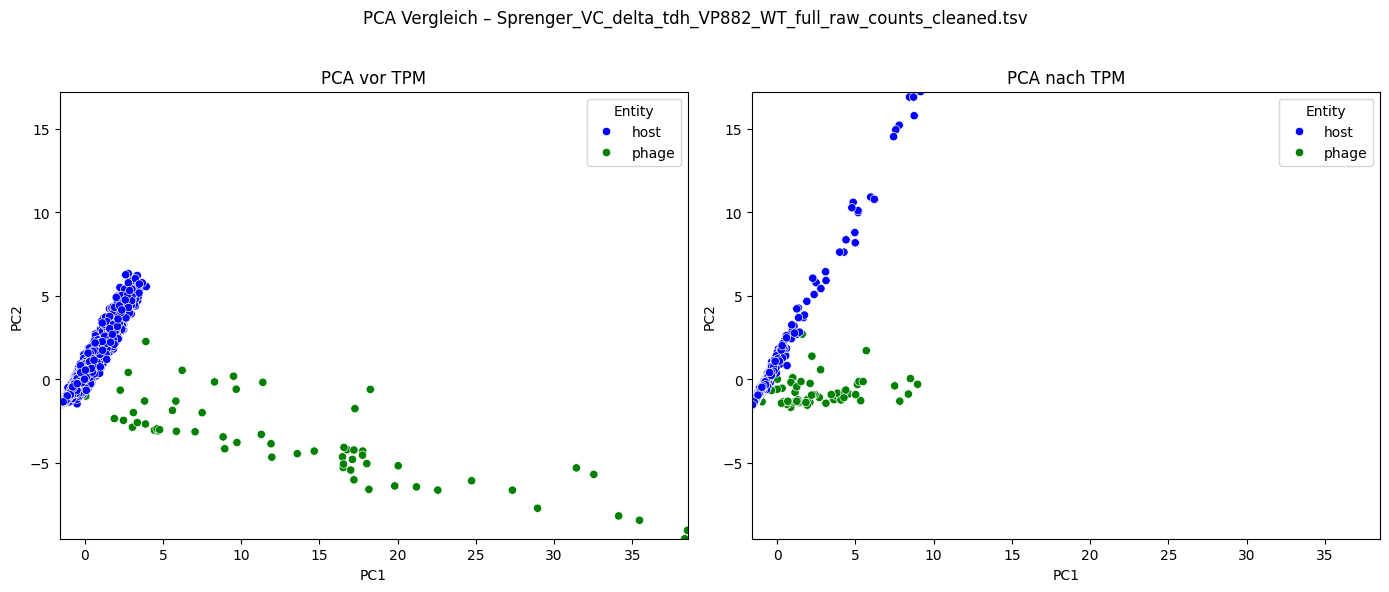

Gespeichert: ../data/normalized_data_bb/Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts_cleaned_TPM.tsv

Verarbeite: Brandao_LB_full_raw_counts_cleaned.tsv


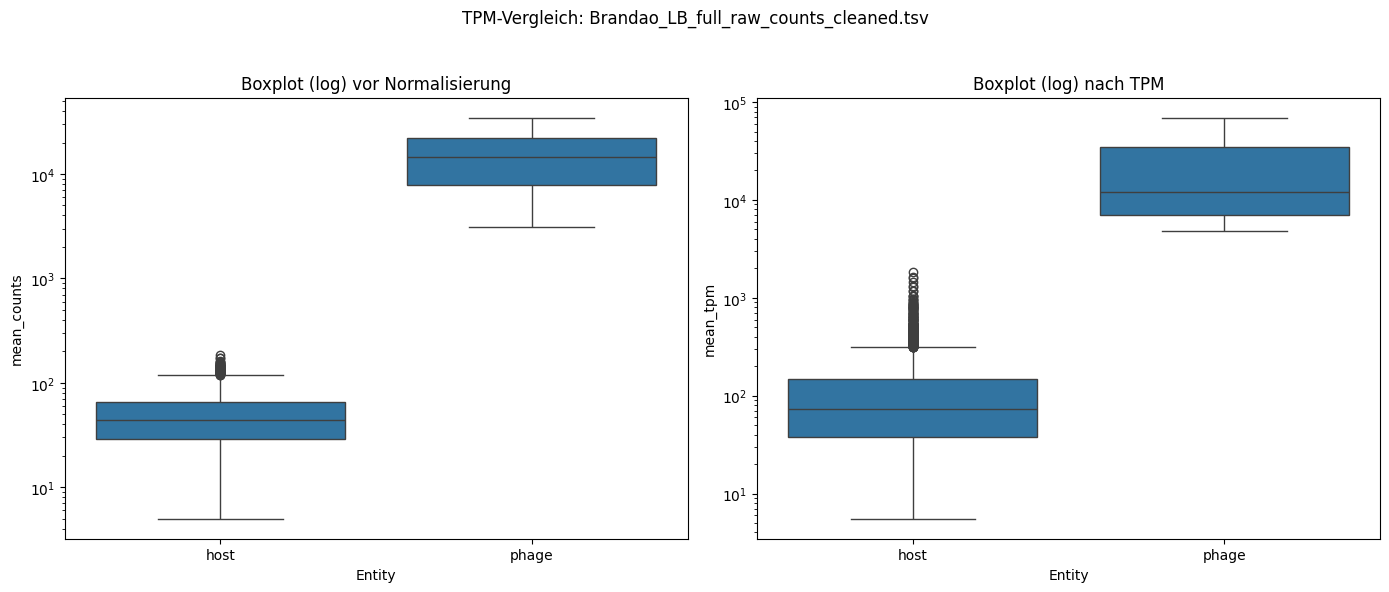

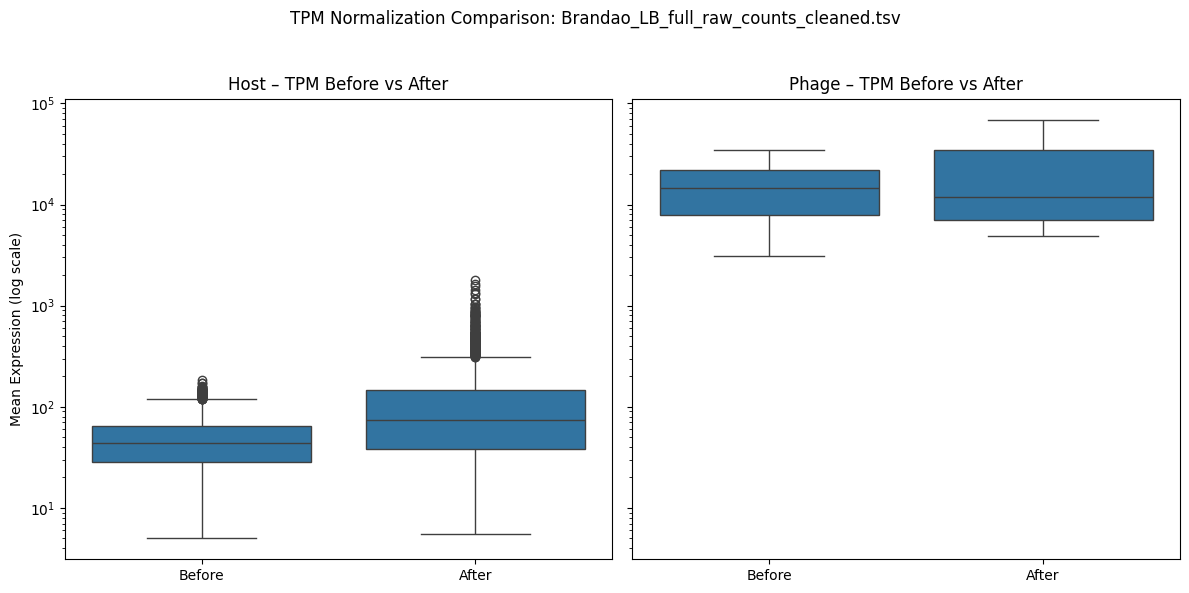

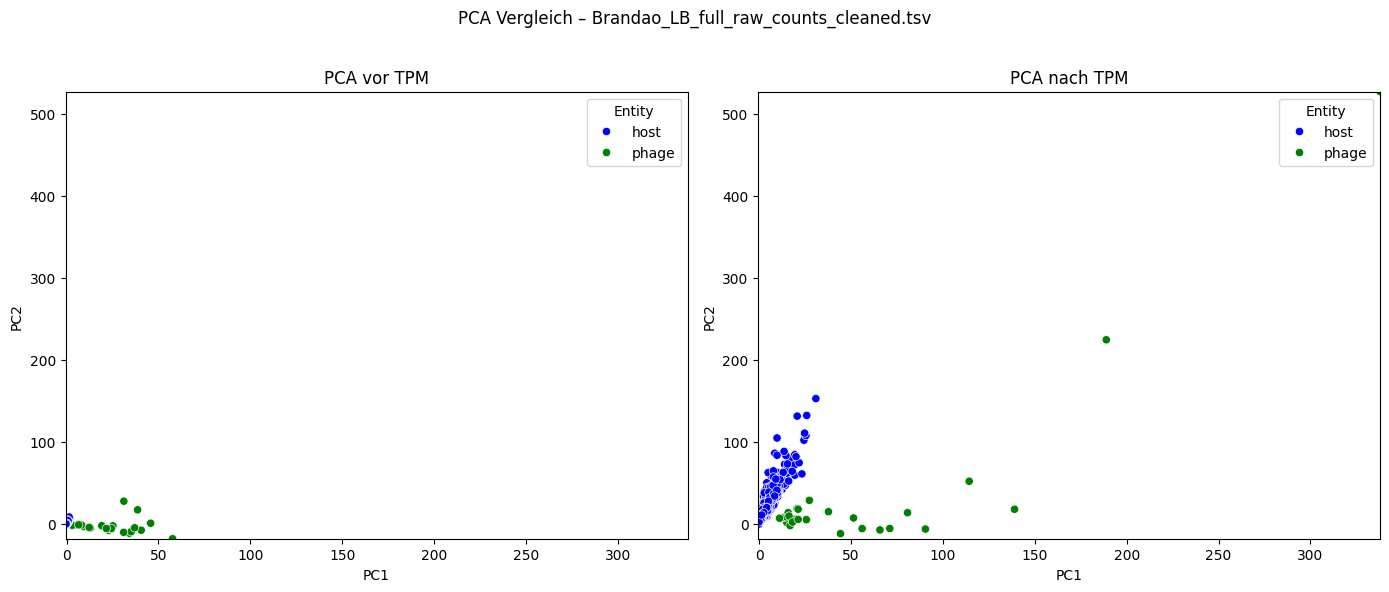

Gespeichert: ../data/normalized_data_bb/Brandao_LB_full_raw_counts_cleaned_TPM.tsv

Verarbeite: Leskinen_full_raw_counts_cleaned.tsv


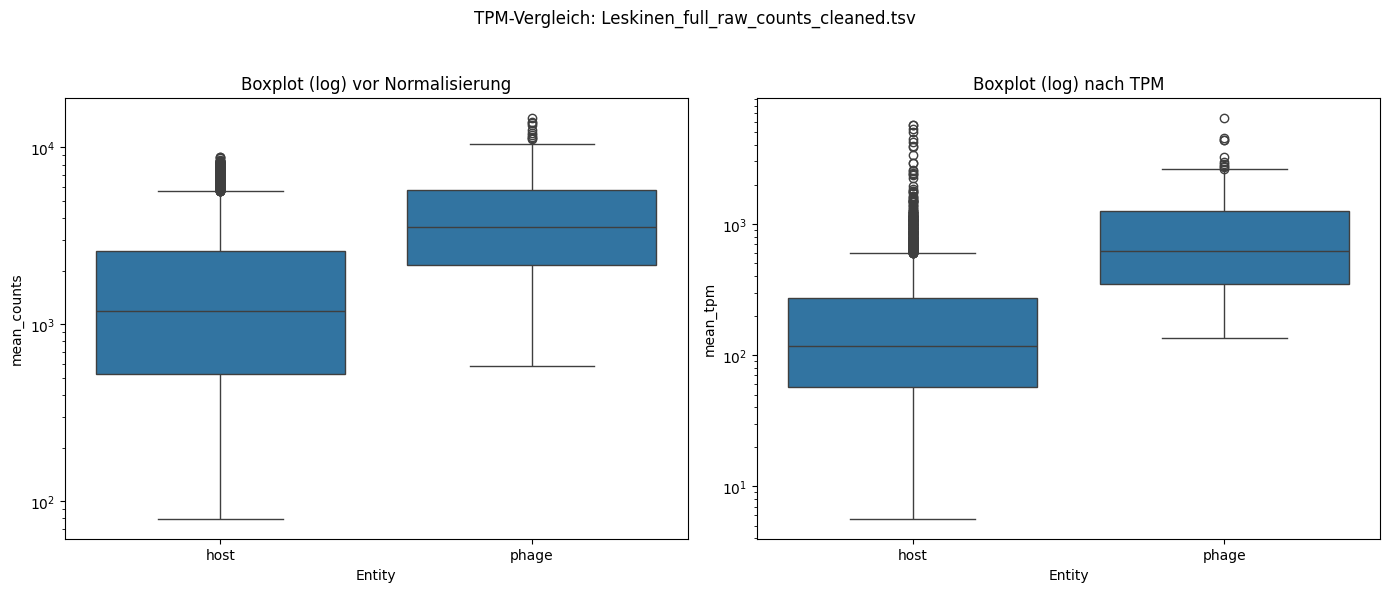

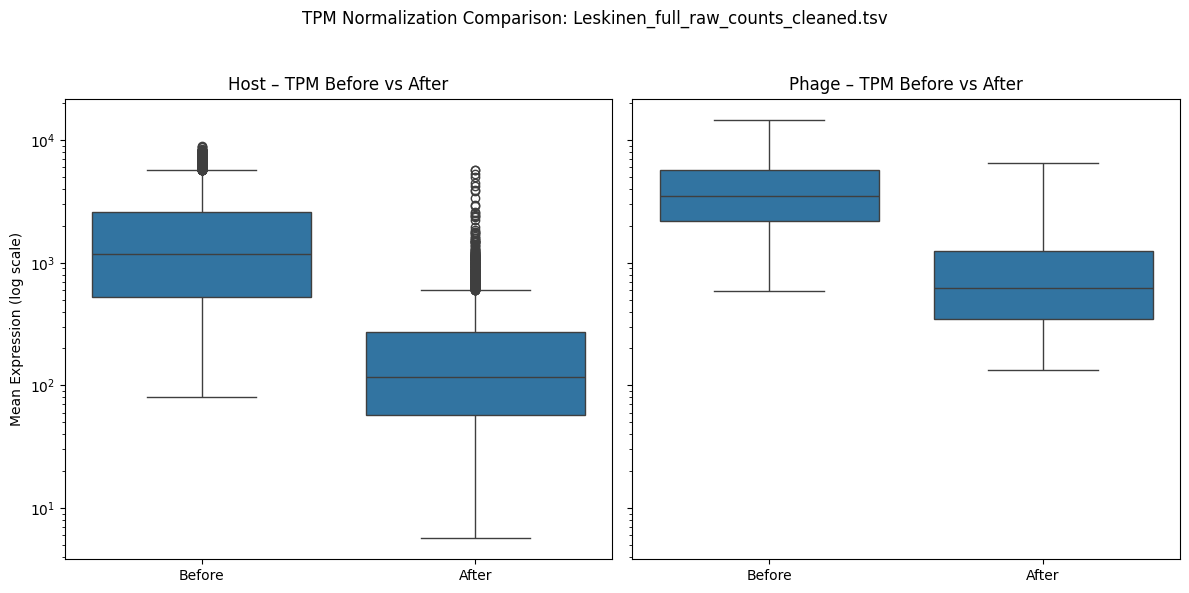

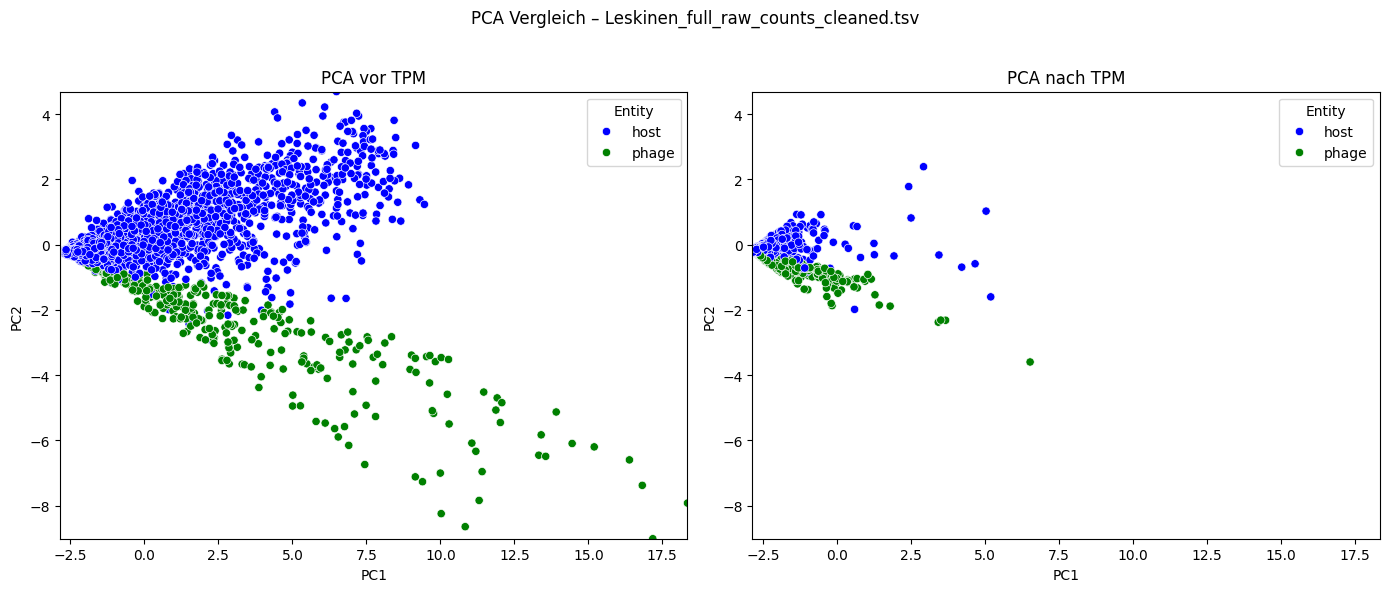

Gespeichert: ../data/normalized_data_bb/Leskinen_full_raw_counts_cleaned_TPM.tsv

Verarbeite: Guegler_T7_minusToxIN_full_raw_counts_cleaned.tsv


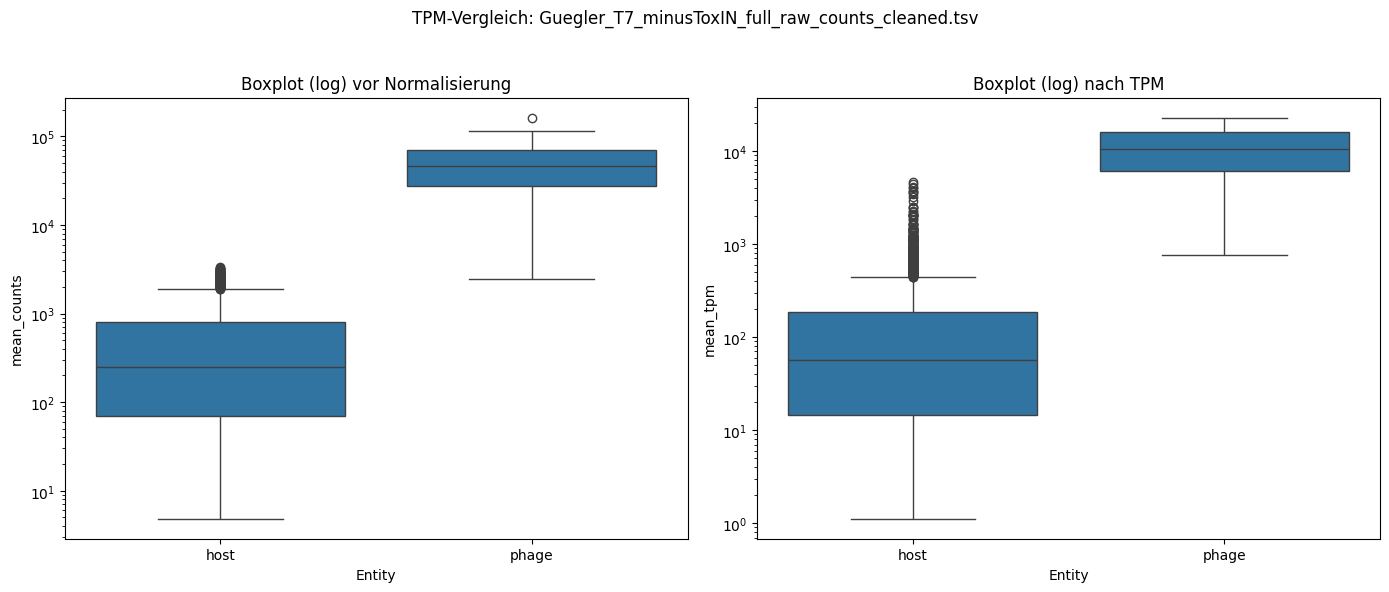

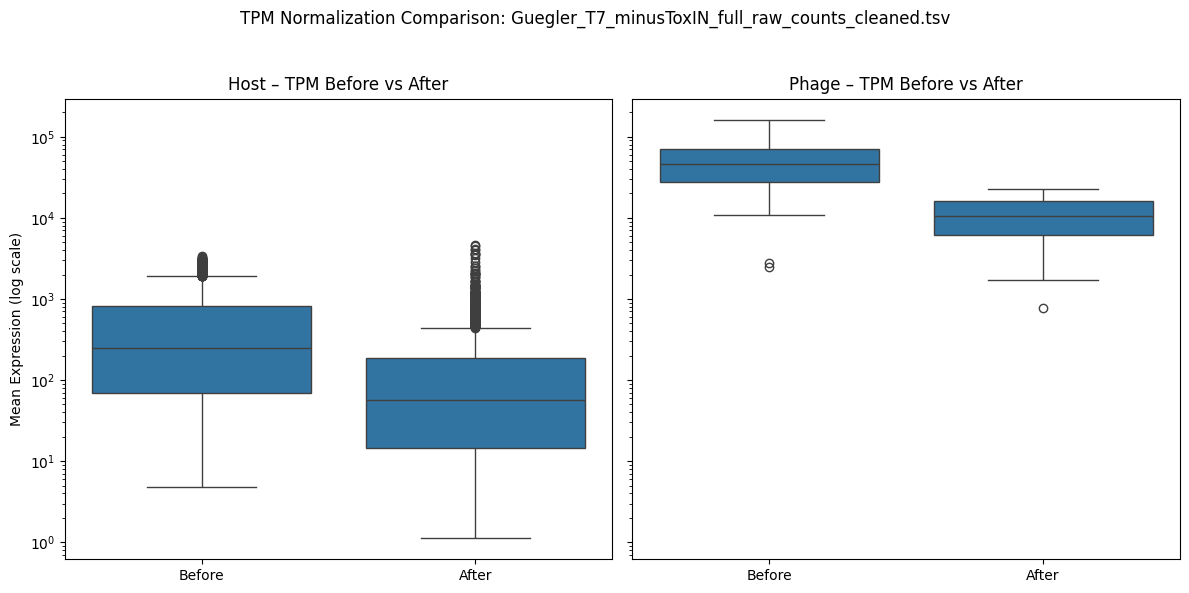

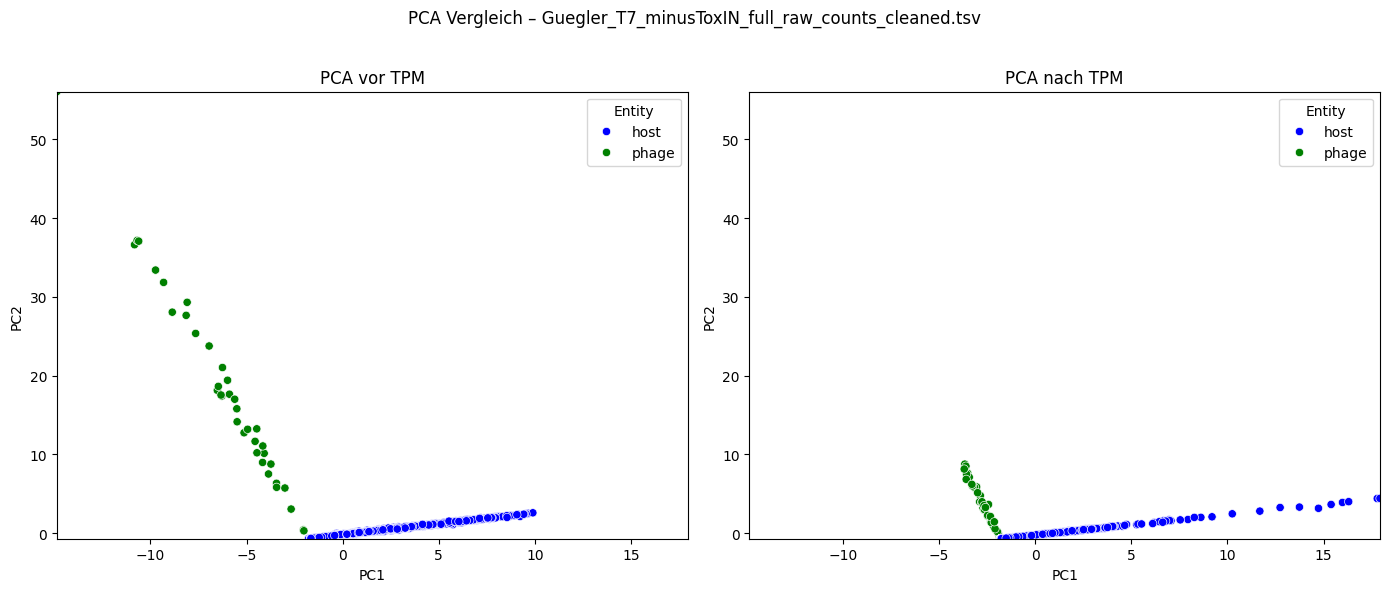

Gespeichert: ../data/normalized_data_bb/Guegler_T7_minusToxIN_full_raw_counts_cleaned_TPM.tsv

Verarbeite: Wolfram-Schauerte_full_raw_counts_cleaned.tsv


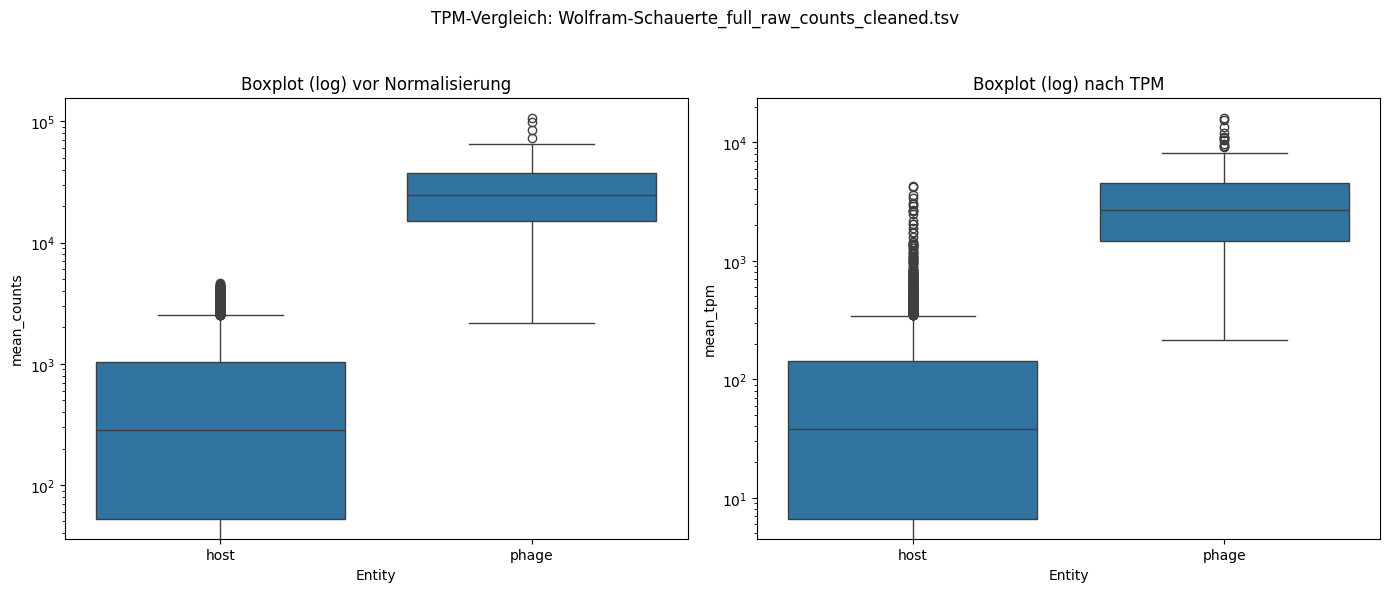

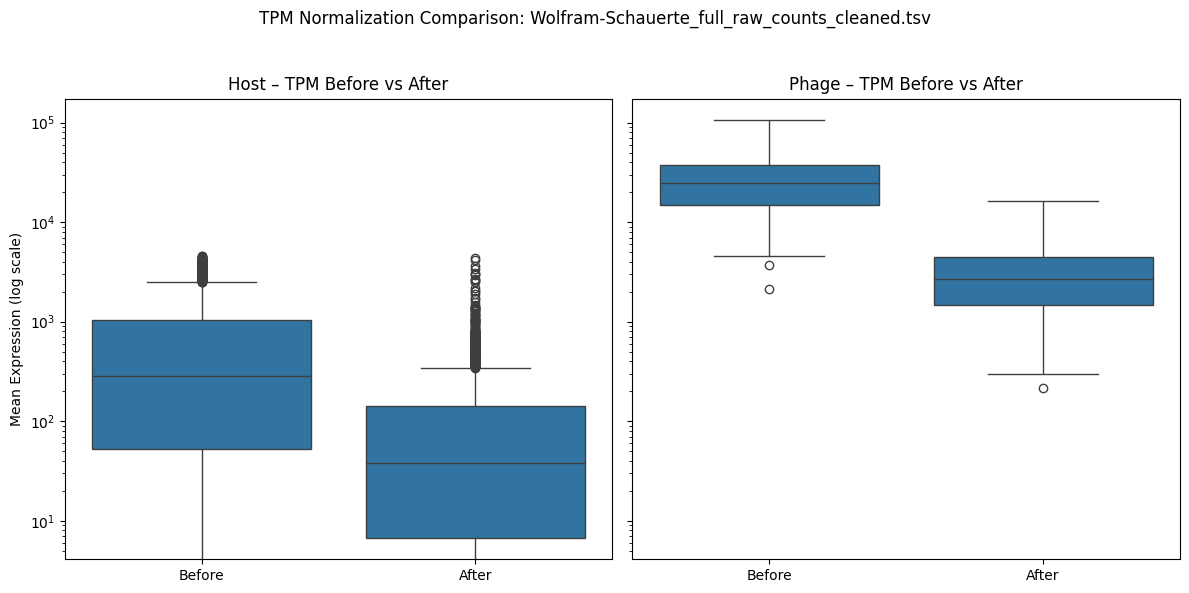

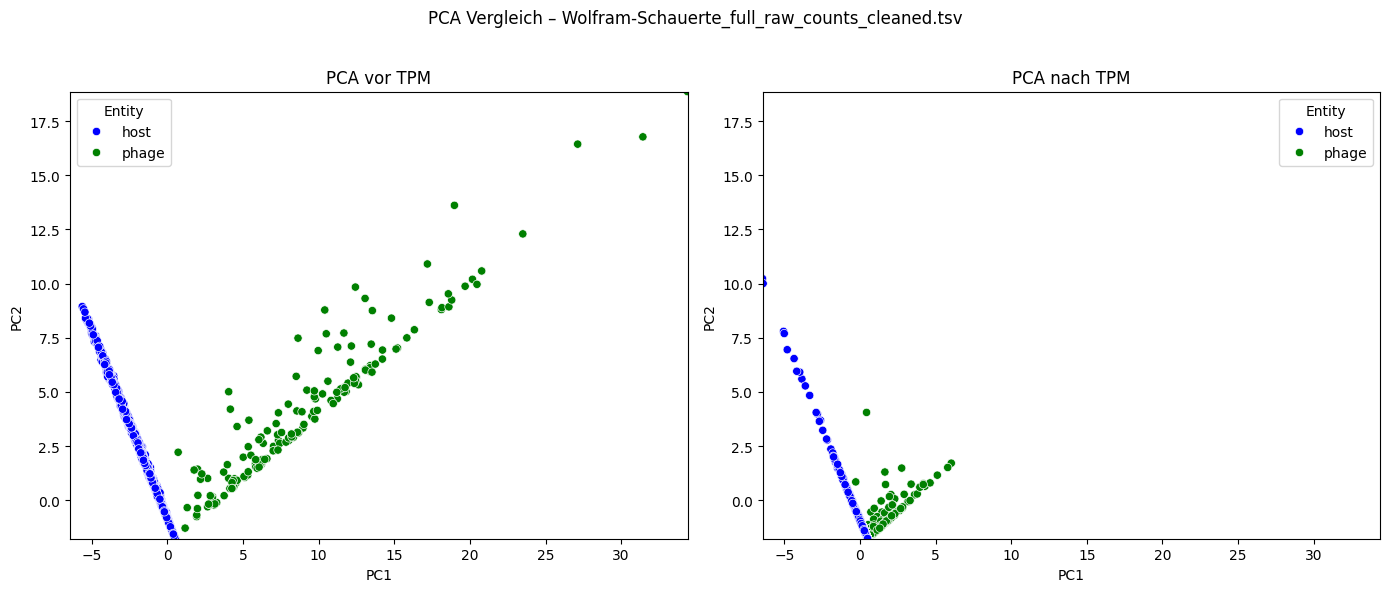

Gespeichert: ../data/normalized_data_bb/Wolfram-Schauerte_full_raw_counts_cleaned_TPM.tsv

Verarbeite: Ceyssens_non-directional_full_raw_counts_cleaned.tsv


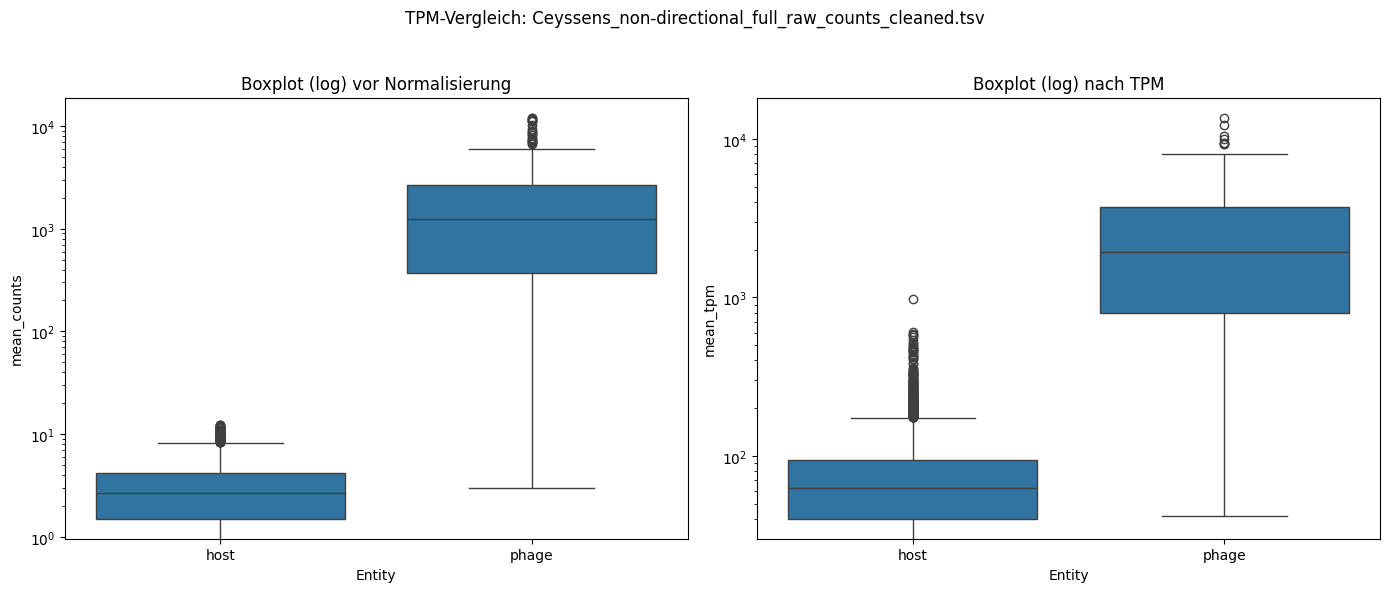

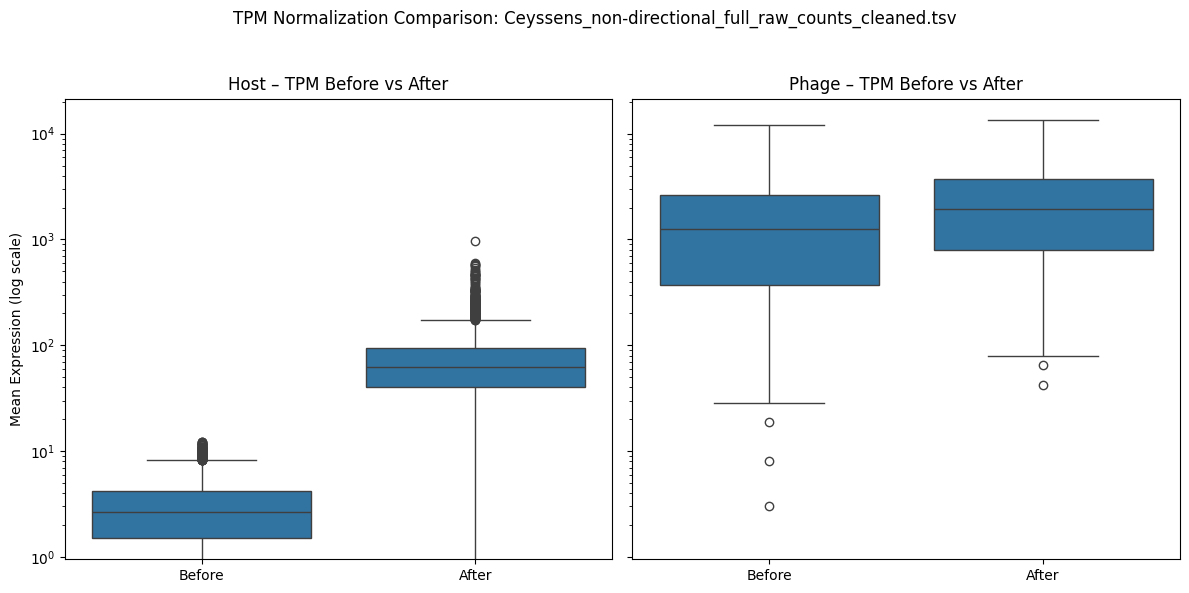

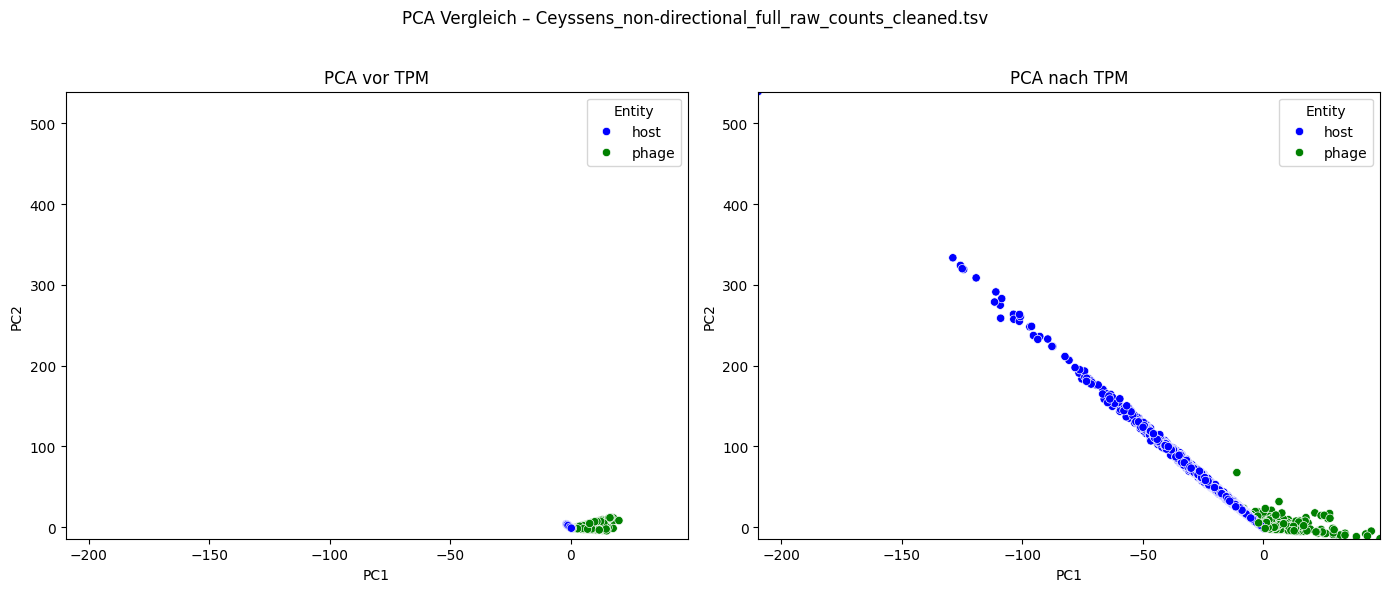

Gespeichert: ../data/normalized_data_bb/Ceyssens_non-directional_full_raw_counts_cleaned_TPM.tsv


In [3]:
# Anwendung auf alle Dateien
for file_path in tsv_files:
    try:
        df = pd.read_csv(file_path, sep='\t')

        gene_col = df.columns[0]
        entity_col = df.columns[-2]
        symbol_col = df.columns[-1]
        count_cols = df.columns[1:-2]

        print(f"\nVerarbeite: {os.path.basename(file_path)}")

        # Gene-Längen aus der entsprechenden GFF-Datei extrahieren
        gene_lengths = {}
        for gff_file in gff_files:
            gene_lengths.update(extract_gene_lengths_from_gff(gff_file))

        # Füge Gene-Length Spalte hinzu
        df['gene_length'] = df[gene_col].map(gene_lengths).fillna(1000)  # Default 1000 wenn keine Länge gefunden

        # Kopie für Originaldaten zur Visualisierung (vor Normalisierung)
        df_original = df.copy()
        
        # TPM-Normalisierung mit tatsächlichen Gen-Längen
        df_tpm = normalize_tpm(df, count_cols, df['gene_length'])

        # Kombiniere mit Metadaten zur Speicherung
        df_tpm[gene_col] = df[gene_col]
        df_tpm['gene_length'] = df['gene_length']
        df_tpm[entity_col] = df[entity_col]
        df_tpm[symbol_col] = df[symbol_col]

        # Spalten sortieren
        ordered_cols = [gene_col] + list(count_cols) + ['gene_length', entity_col, symbol_col]
        df_tpm = df_tpm[ordered_cols]

        # Visualisierung 1
        visualize_tpm_boxplot_only(df.copy(), df_tpm.copy(), count_cols, entity_col, file_path)

        # Visualisierung 2 
        visualize_tpm_boxplot_entitywise(df_original.copy(), df_tpm.copy(), count_cols, entity_col, file_path)

        # Visualisierung 3: PCA
        visualize_pca_comparison(df_original.copy(), df_tpm.copy(), count_cols, entity_col, file_path)

        # Speichern
        out_path = os.path.join(output_dir, os.path.basename(file_path).replace('.tsv', '_TPM.tsv'))
        df_tpm.to_csv(out_path, sep='\t', index=False)
        print(f"Gespeichert: {out_path}")

    except Exception as e:
        print(f"Fehler bei Datei {file_path}: {e}")